In [82]:
import numpy as np
from matplotlib import pyplot as plt
import glob, sys, pickle, sobol_seq, numpy
from scipy.stats import norm, truncnorm, multivariate_normal
from scipy.special import logsumexp
from tqdm import tqdm
import pandas as pd
import copy
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [83]:
data = pd.read_csv('C:/Users/canlab/Desktop/Modelling_Influenca/App_data/All_subjects_data.csv')

In [69]:
data

,Unnamed: 0,ID,Trial,Run,drawn_outcome,choice,win,p_reward_a
0,0,2,1,1,1,0,0,0.800000
1,1,2,2,1,0,1,0,0.787411
2,2,2,3,1,0,0,1,0.708686
3,3,2,4,1,0,0,1,0.610199
4,4,2,5,1,0,0,1,0.616570
...,...,...,...,...,...,...,...,...
568645,568645,353,146,1,1,1,1,0.390209
568646,568646,353,147,1,1,1,1,0.473773
568647,568647,353,148,1,0,1,0,0.463202
568648,568648,353,149,1,1,1,1,0.560426


In [84]:
def get_dataframe(data, sub, run_num):
    # true data
    data_       = data[data['ID']==sub]
    
    # simulated data
    sub_p_a     = np.load('C:/Users/canlab/Desktop/Modelling_Influenca/Results/All_Subjects/Simulation/subject_{}_p_a_median.pkl'.format(sub), allow_pickle=True)
    sub_choices = np.load('C:/Users/canlab/Desktop/Modelling_Influenca/Results/All_Subjects/Simulation/subject_{}_simulated_choices.pkl'.format(sub), allow_pickle=True)
    
    
    run_        = data_[data_['Run']==run_num]
    
    # p_A for 3 models
    sub_p_a_wb  = sub_p_a[0]
    sub_p_a_wh  = sub_p_a[1]
    sub_p_a_nn  = sub_p_a[2]
    
    # simulated choices for 3 models
    sub_c_wb    = sub_choices[0]
    sub_c_wh    = sub_choices[1]
    sub_c_nn    = sub_choices[2]
    
    # true choice and p_A
    choice      = run_['choice'].to_numpy()
    p_a_true    = run_['p_reward_a'].to_numpy()
    
    
    # create dataframes for the models
    df_           = pd.DataFrame()
    df_wb         = pd.DataFrame(sub_p_a_wb[0])
    df_wb.columns =['Weber: p_A', 'Weber: p_B']
    df_wb['Weber: simulated choice']= pd.Series(sub_c_wb[0])
    
    df_wh         = pd.DataFrame(sub_p_a_wh[0])
    df_wh.columns = ['White: p_A', 'White: p_B']
    df_wh['White: simulated choice']= pd.Series(sub_c_wh[0])
    
    df_nn         = pd.DataFrame(sub_p_a_nn[0])
    df_nn.columns = ['None: p_A', 'None: p_B']
    df_nn['None: simulated choice']= pd.Series(sub_c_nn[0])
    
    df_['True p_A']= pd.Series(p_a_true)
    df_['True choice']= pd.Series(choice)

    df_ =pd.concat([df_, df_wb, df_wh, df_nn], axis=1)
    df_[['True choice','Weber: simulated choice','White: simulated choice', 'None: simulated choice']]=df_[['True choice','Weber: simulated choice','White: simulated choice', 'None: simulated choice']].replace([0,1], ['A', 'B'])
    print(df_)
    
    return df_

In [91]:
def visualize(df_, sub, run_num, noise, choice):
    #%matplotlib notebook
    
    plt.figure(figsize=(15, 8))
    sns.color_palette("pastel")
    
    str_ = noise + ': p_A'
    
    if choice =='True':
        str_c = 'True choice'
        print(str_c)
    elif choice == 'simulated':
        str_c = noise + ': simulated choice'
        print(str_c)
    else: 
        print('wrong choice option')
    
    sns.lineplot(data=df_, x=df_.index, y=df_['True p_A'], color='black')
    ax=sns.scatterplot(data=df_, x=df_.index, y=df_[str_], hue=df_[str_c], hue_order = ['A', 'B'],palette=['orange','blue'], alpha=0.4, s=100, legend= 'full')
    #sns.scatterplot(data=df_, x=df_.index, y=df_['p_A'], hue=df_['True choice'], hue_order = ['A_true', 'B_true'],palette=['red','green'], alpha=0.4, s=100, legend= 'full')
    ax.legend(fontsize = 15, bbox_to_anchor= (1.03, 1),title="Choice", title_fontsize = 15)
    sns.despine(top=True,offset=5)
    plt.xlabel('Trial', fontsize=24)
    plt.ylabel('win probability choice A', fontsize=24)
    plt.tick_params(labelsize=16)
    title_= noise + ' noise'
    plt.title(title_, fontsize=24)
    sns.despine(top=True,offset=5)
    plt.tight_layout()
    
    plt.savefig('C:/Users/canlab/Desktop/Modelling_Influenca/Results/Subject_{}_Run_{}_noise_{}_choice_{}'.format(sub,run_num, noise, choice), dpi=250)
    
    
    
    
    
    
    

In [72]:
df=get_dataframe(data, 4, 20)

     True p_A True choice  Weber: p_A  Weber: p_B Weber: simulated choice  \
0    0.200000           A    0.500000    0.500000                       B   
1    0.236083           A    0.339990    0.660010                       B   
2    0.217995           A    0.839601    0.160399                       A   
3    0.132340           A    0.915420    0.084580                       A   
4    0.245192           A    0.739307    0.260693                       A   
..        ...         ...         ...         ...                     ...   
145  0.390417           B    0.228142    0.771858                       B   
146  0.421500           B    0.929381    0.070619                       A   
147  0.477144           B    0.938460    0.061540                       A   
148  0.362446           B    0.924315    0.075685                       A   
149  0.405587           B    0.814640    0.185360                       A   

     White: p_A  White: p_B White: simulated choice  None: p_A  None: p_B  

<IPython.core.display.Javascript object>


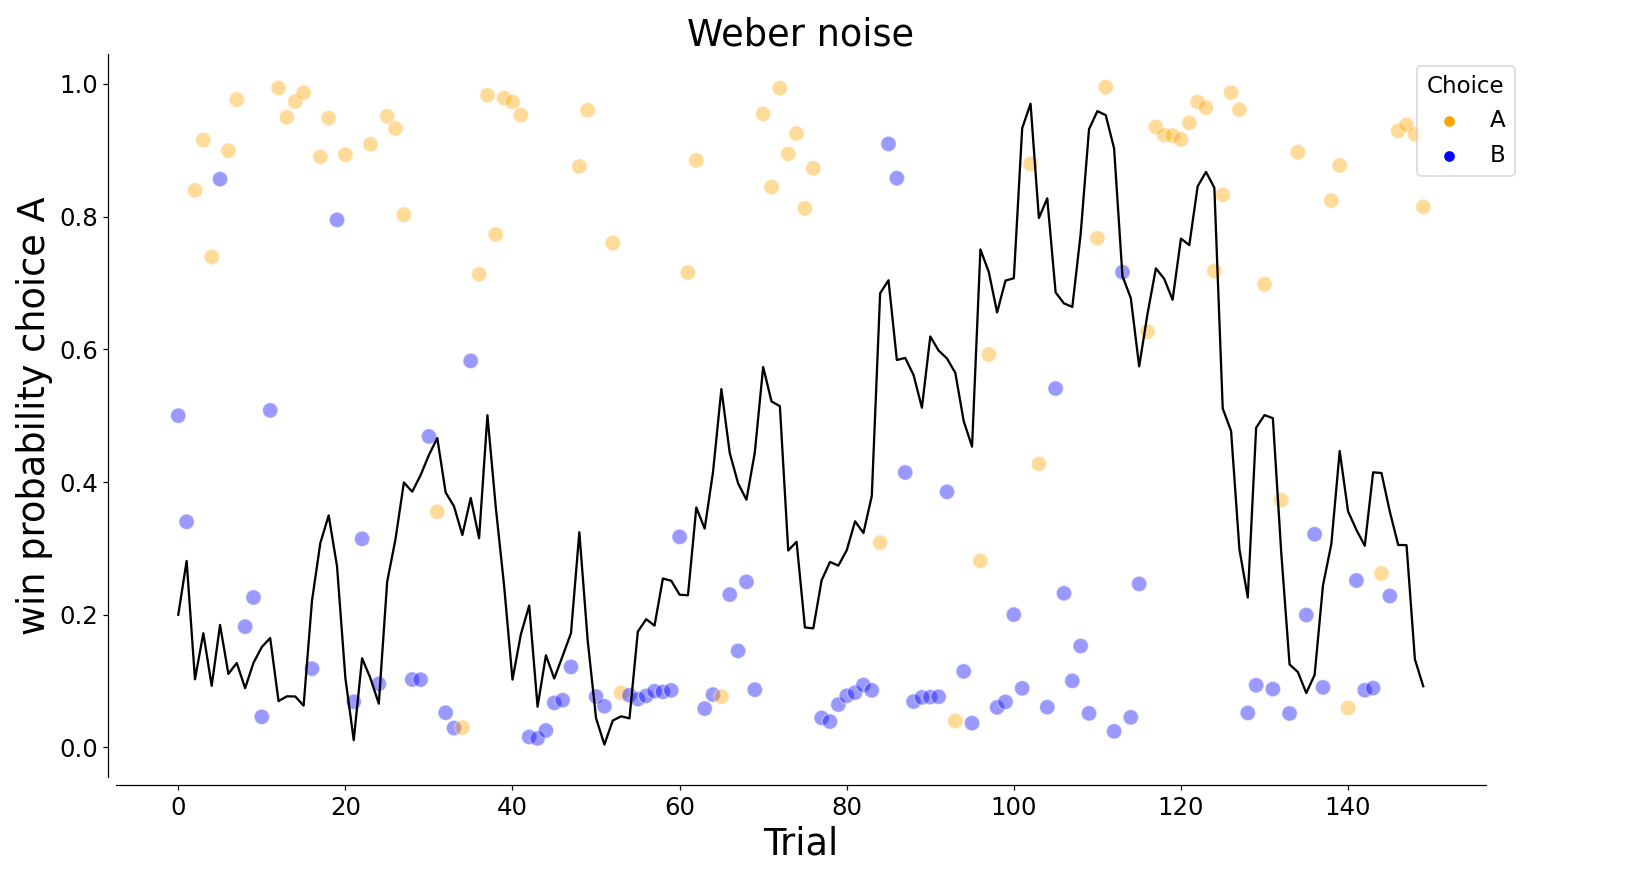

Weber: simulated choice


In [87]:
visualize(df, 4, 20, 'Weber', 'simulated')

<IPython.core.display.Javascript object>


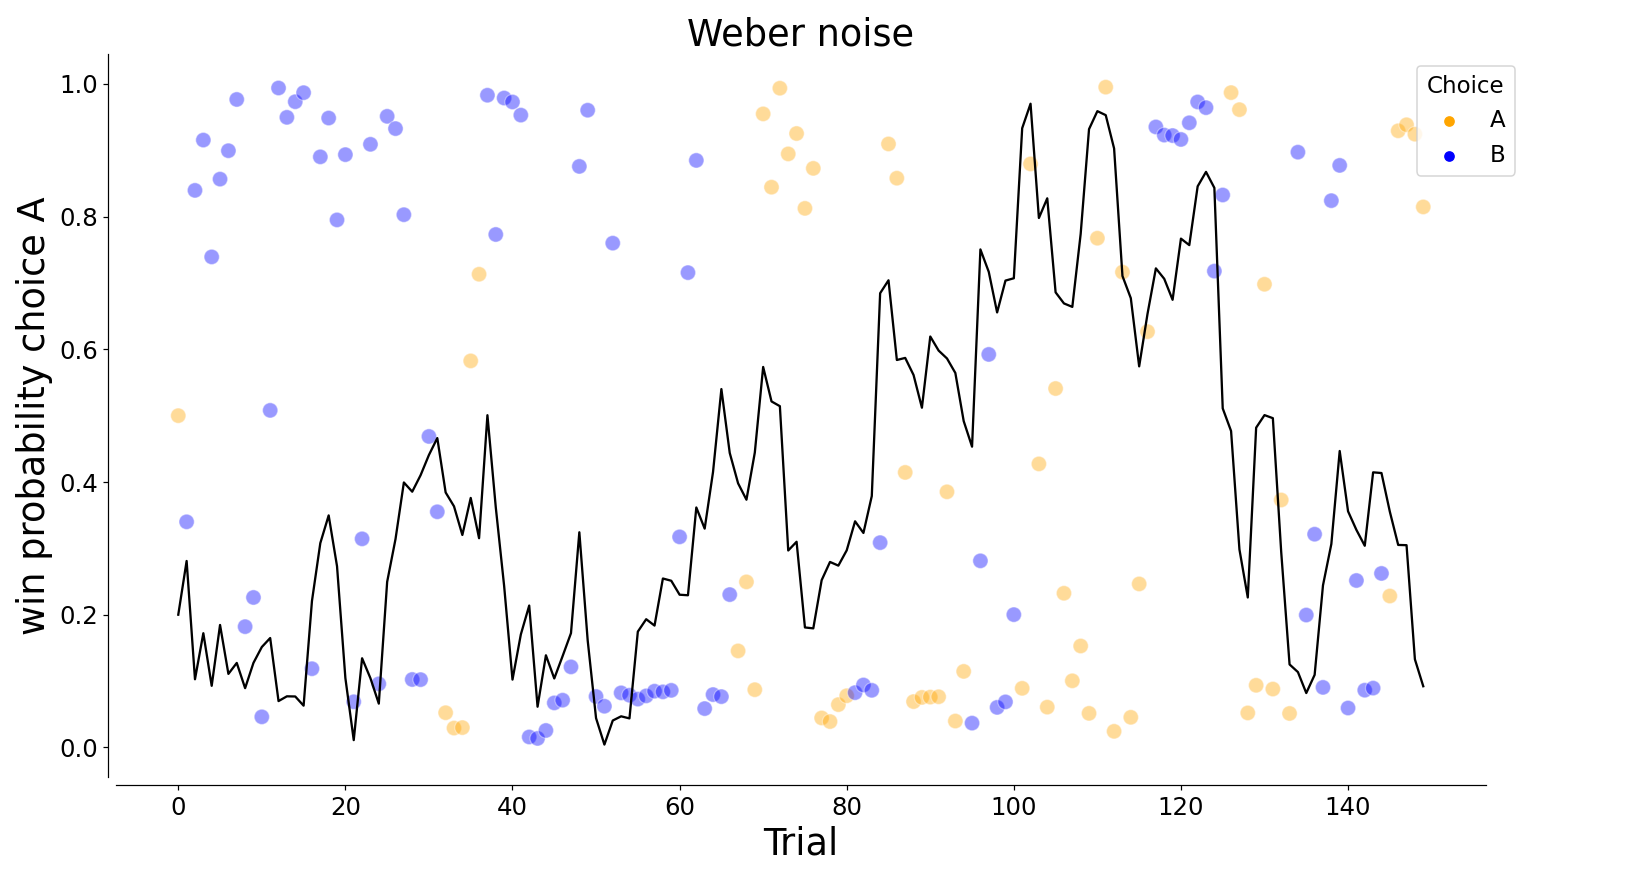

True choice


In [88]:
visualize(df, 4, 20, 'Weber', 'True')

In [44]:
df[['True choice']]

,True choice
0,A
1,A
2,A
3,A
4,A
...,...
145,B
146,B
147,B
148,B


<IPython.core.display.Javascript object>


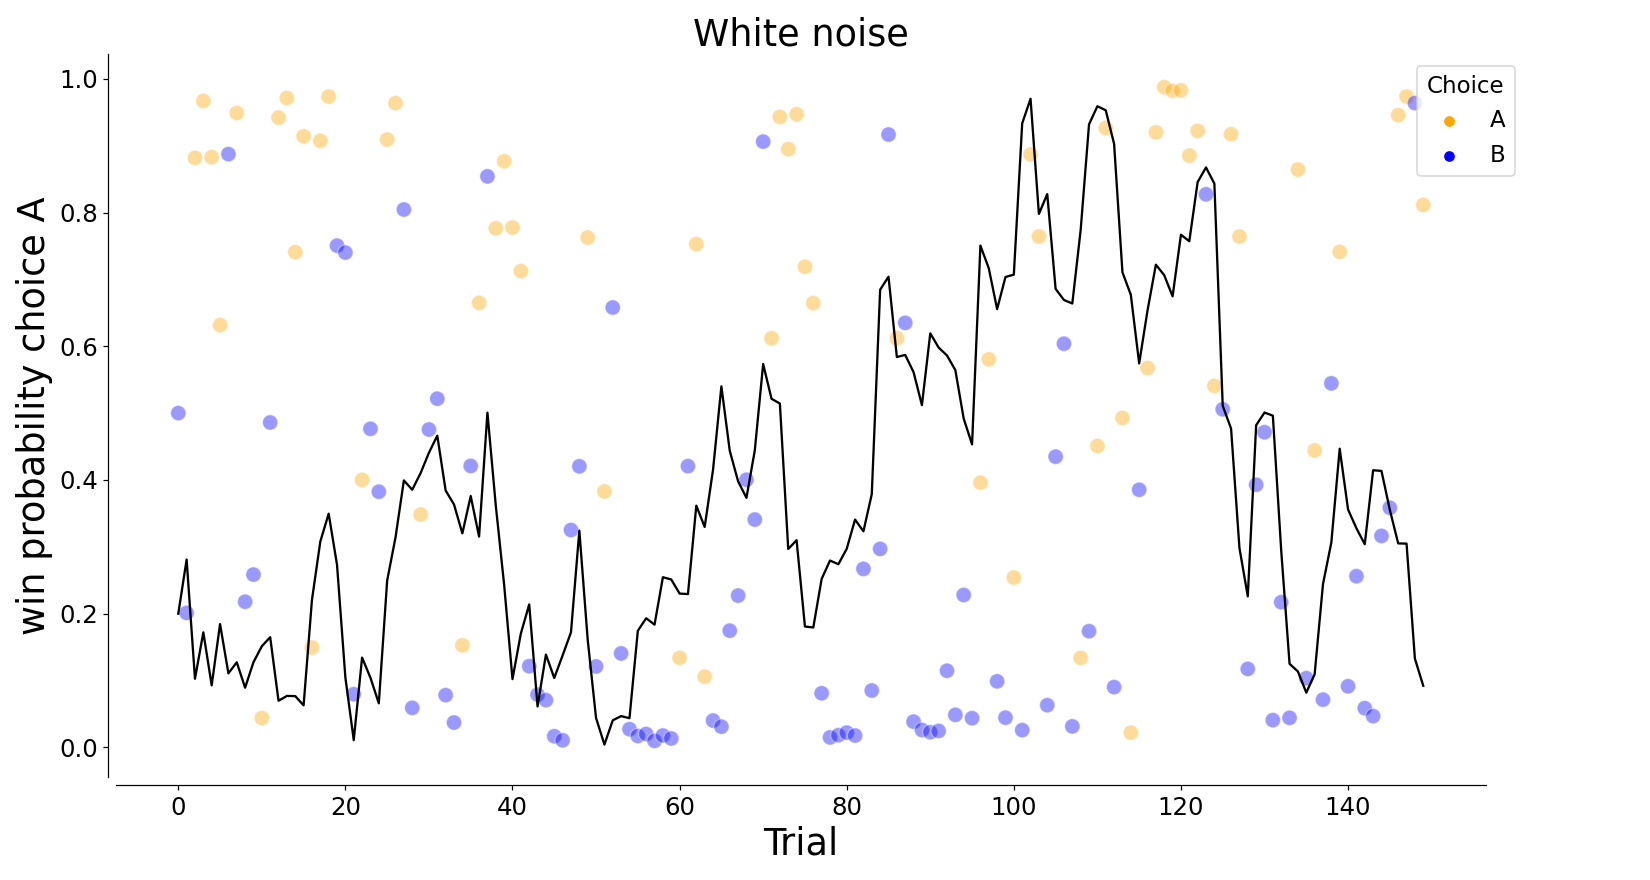

White: simulated choice


<IPython.core.display.Javascript object>


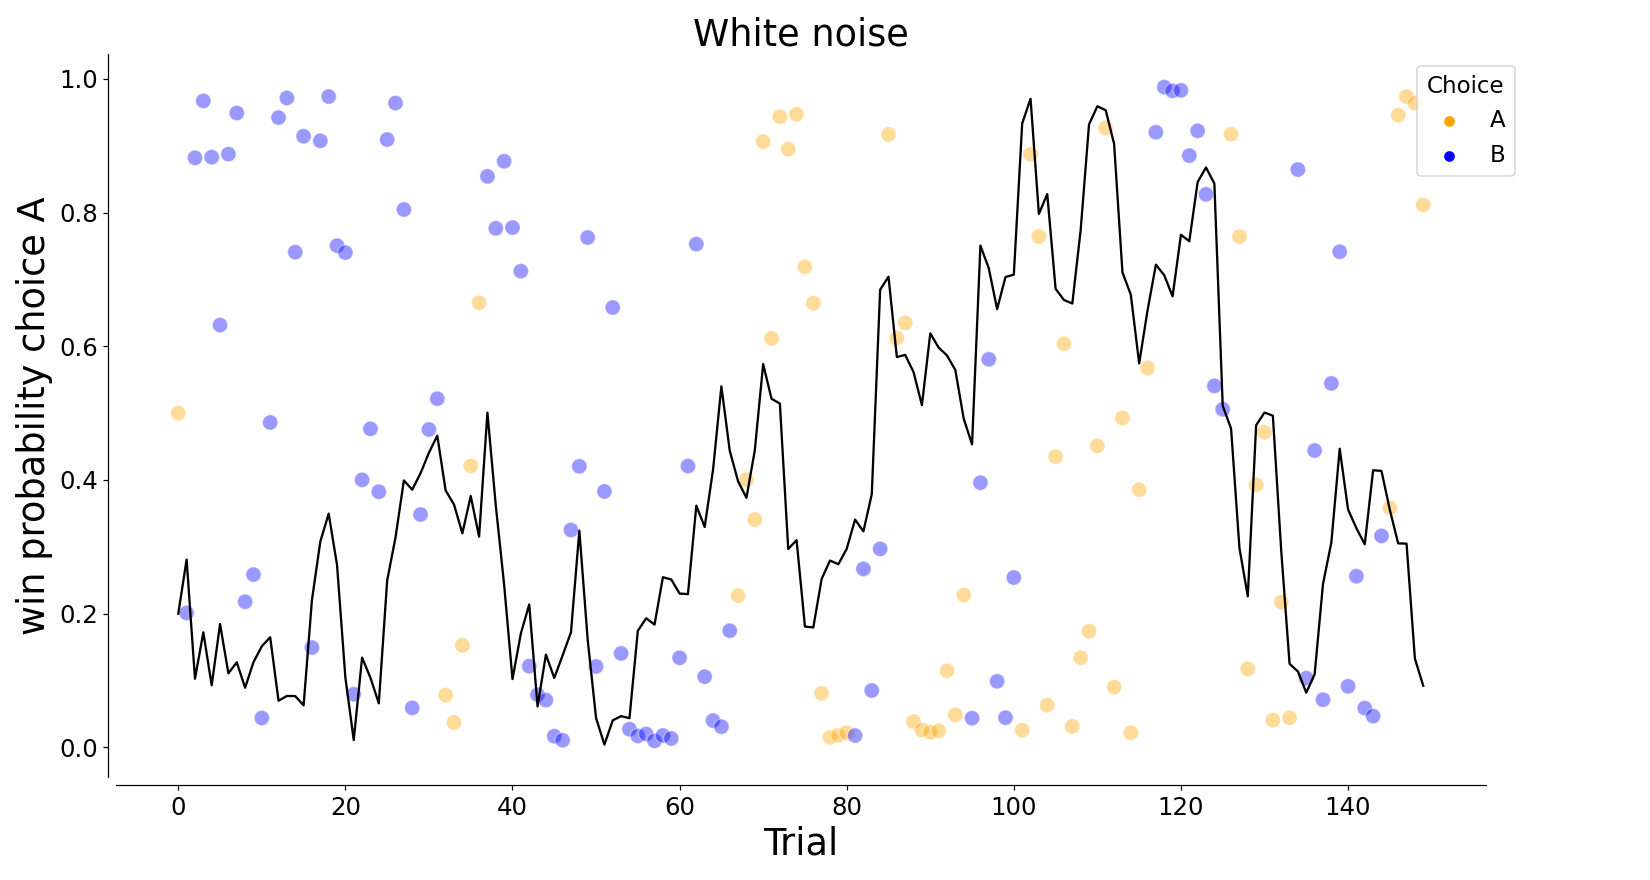

True choice


<IPython.core.display.Javascript object>


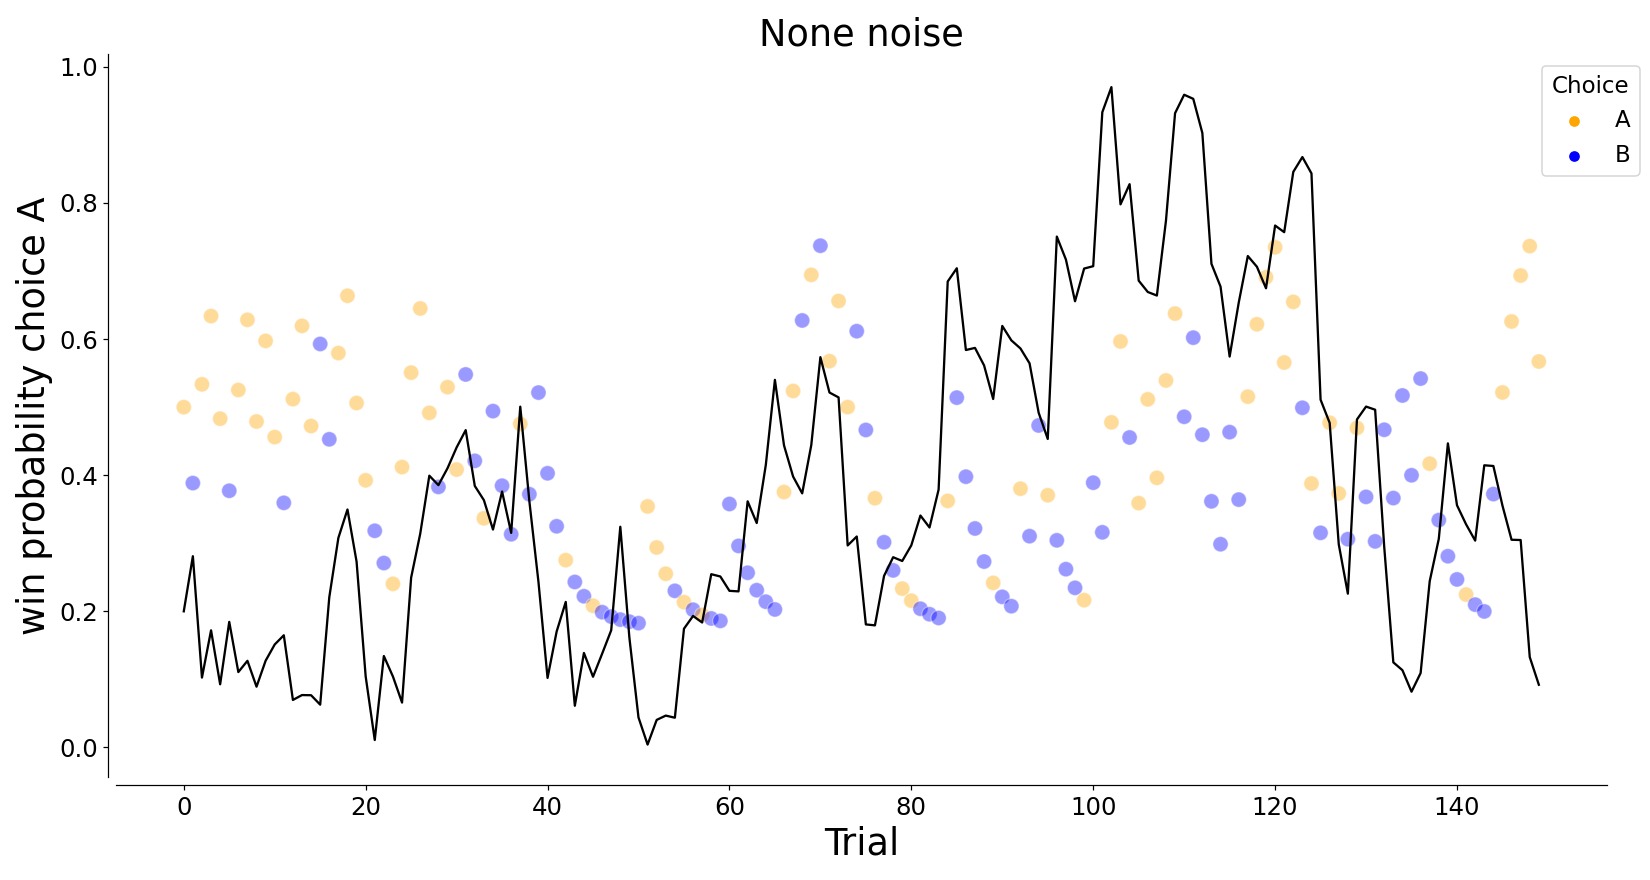

None: simulated choice


<IPython.core.display.Javascript object>


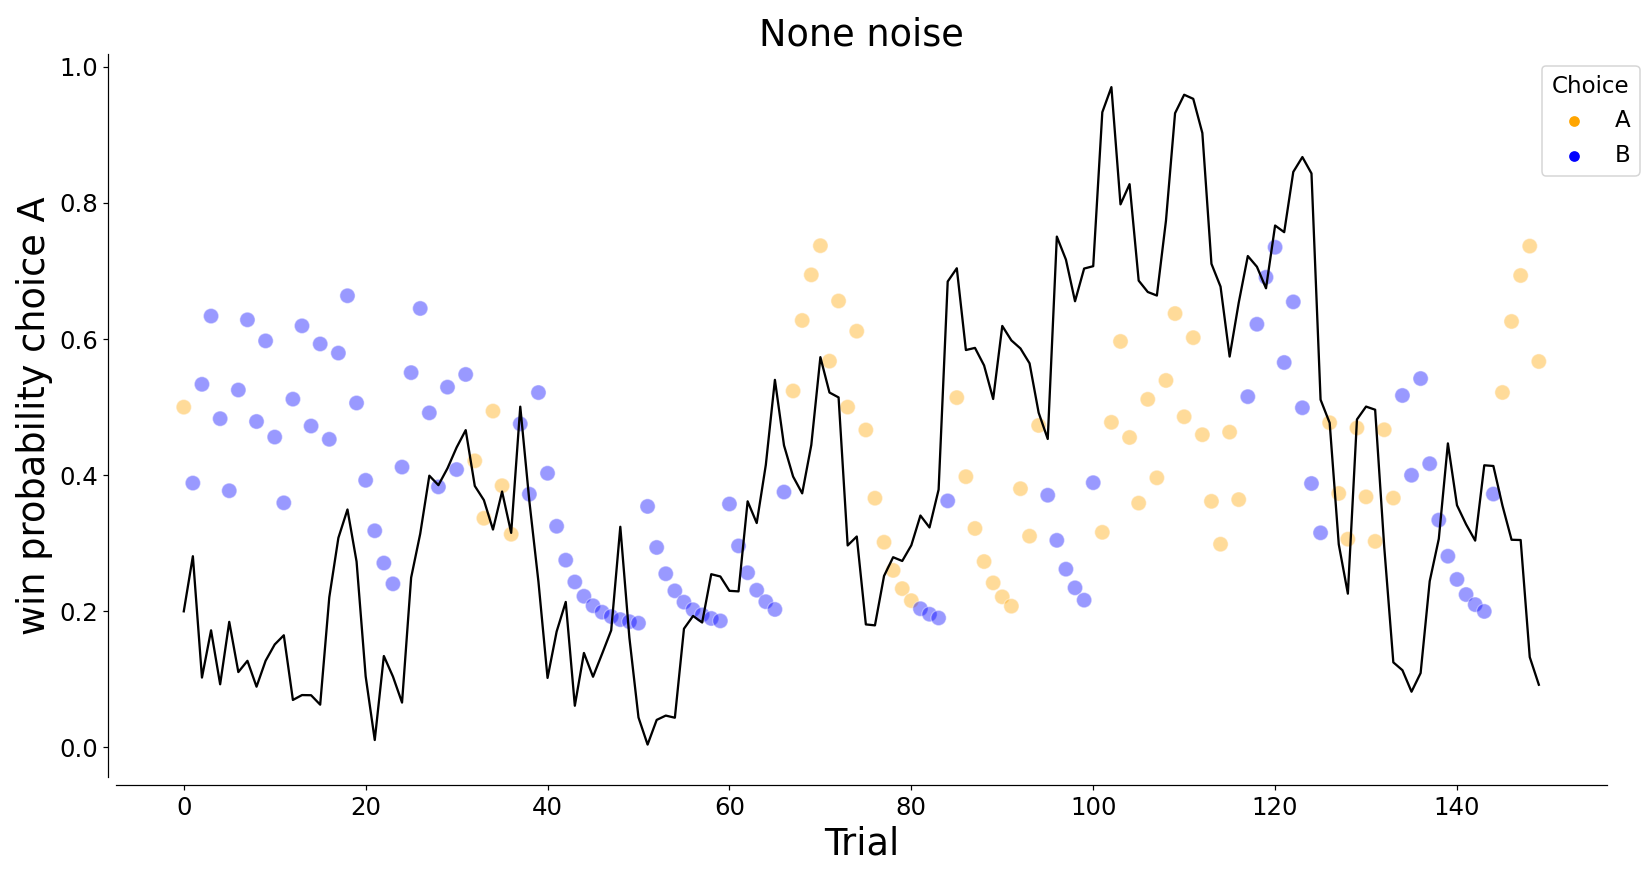

True choice


In [93]:
visualize(df, 4, 20, 'White', 'simulated')
visualize(df, 4, 20, 'White', 'True')
visualize(df, 4, 20, 'None', 'simulated')
visualize(df, 4, 20, 'None', 'True')

In [80]:
df=get_dataframe(data, 4, 24)

     True p_A True choice  Weber: p_A  Weber: p_B Weber: simulated choice  \
0    0.200000           A    0.500000    0.500000                       B   
1    0.280981           B    0.339990    0.660010                       B   
2    0.102685           B    0.839601    0.160399                       A   
3    0.172086           B    0.915420    0.084580                       A   
4    0.092809           B    0.739307    0.260693                       A   
..        ...         ...         ...         ...                     ...   
145  0.355322           A    0.228142    0.771858                       B   
146  0.305157           A    0.929381    0.070619                       A   
147  0.304784           A    0.938460    0.061540                       A   
148  0.132781           A    0.924315    0.075685                       A   
149  0.092146           A    0.814640    0.185360                       A   

     White: p_A  White: p_B White: simulated choice  None: p_A  None: p_B  

<IPython.core.display.Javascript object>


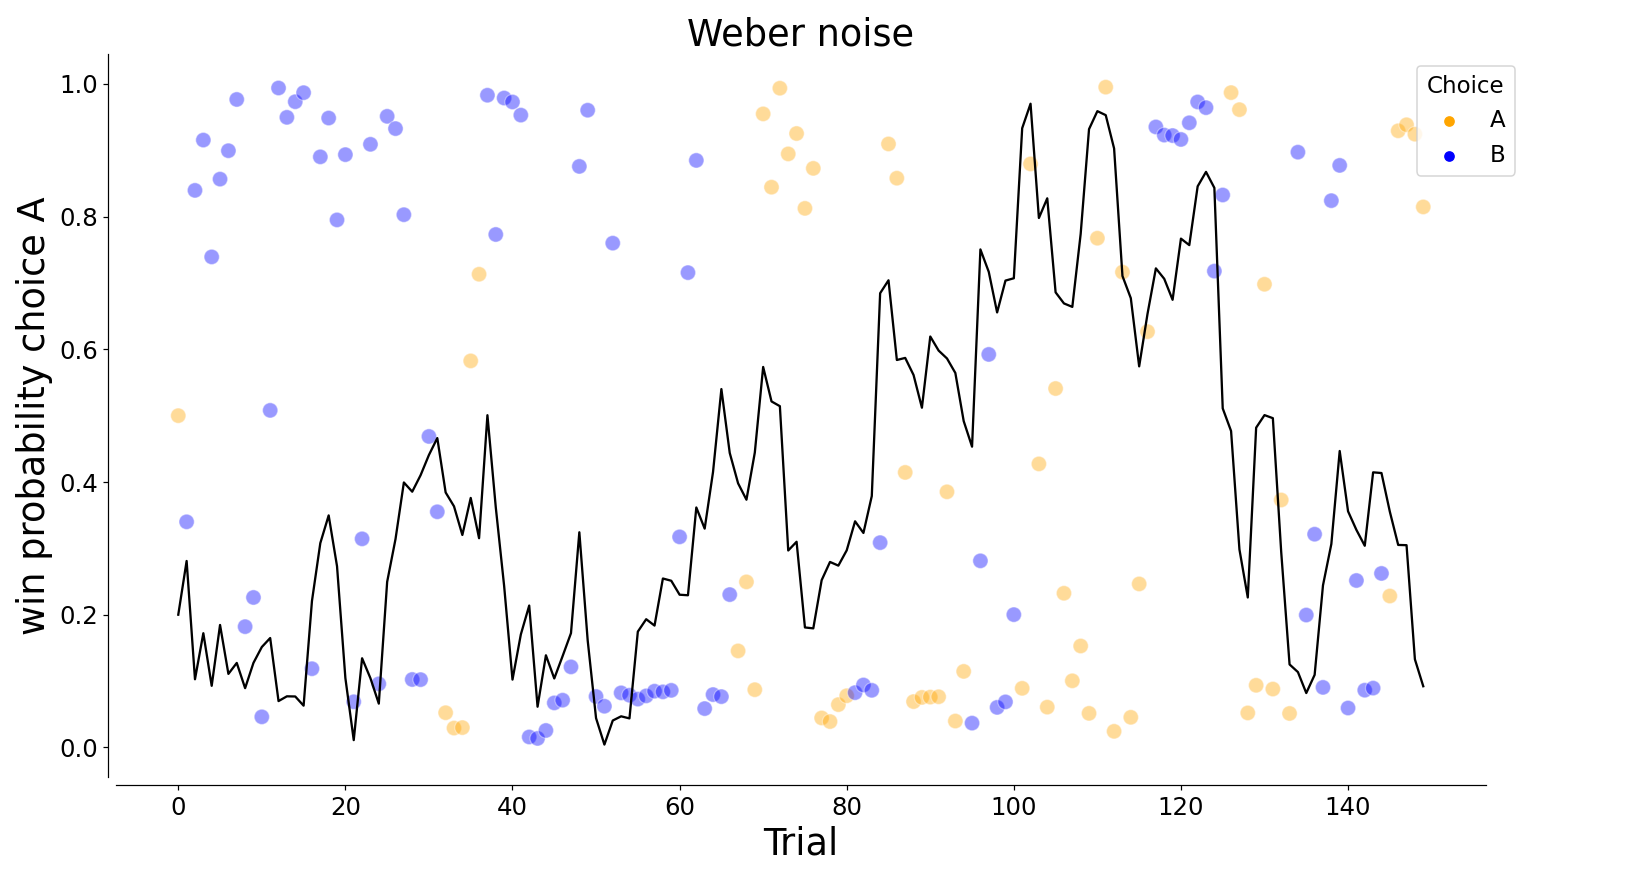

True choice


<IPython.core.display.Javascript object>


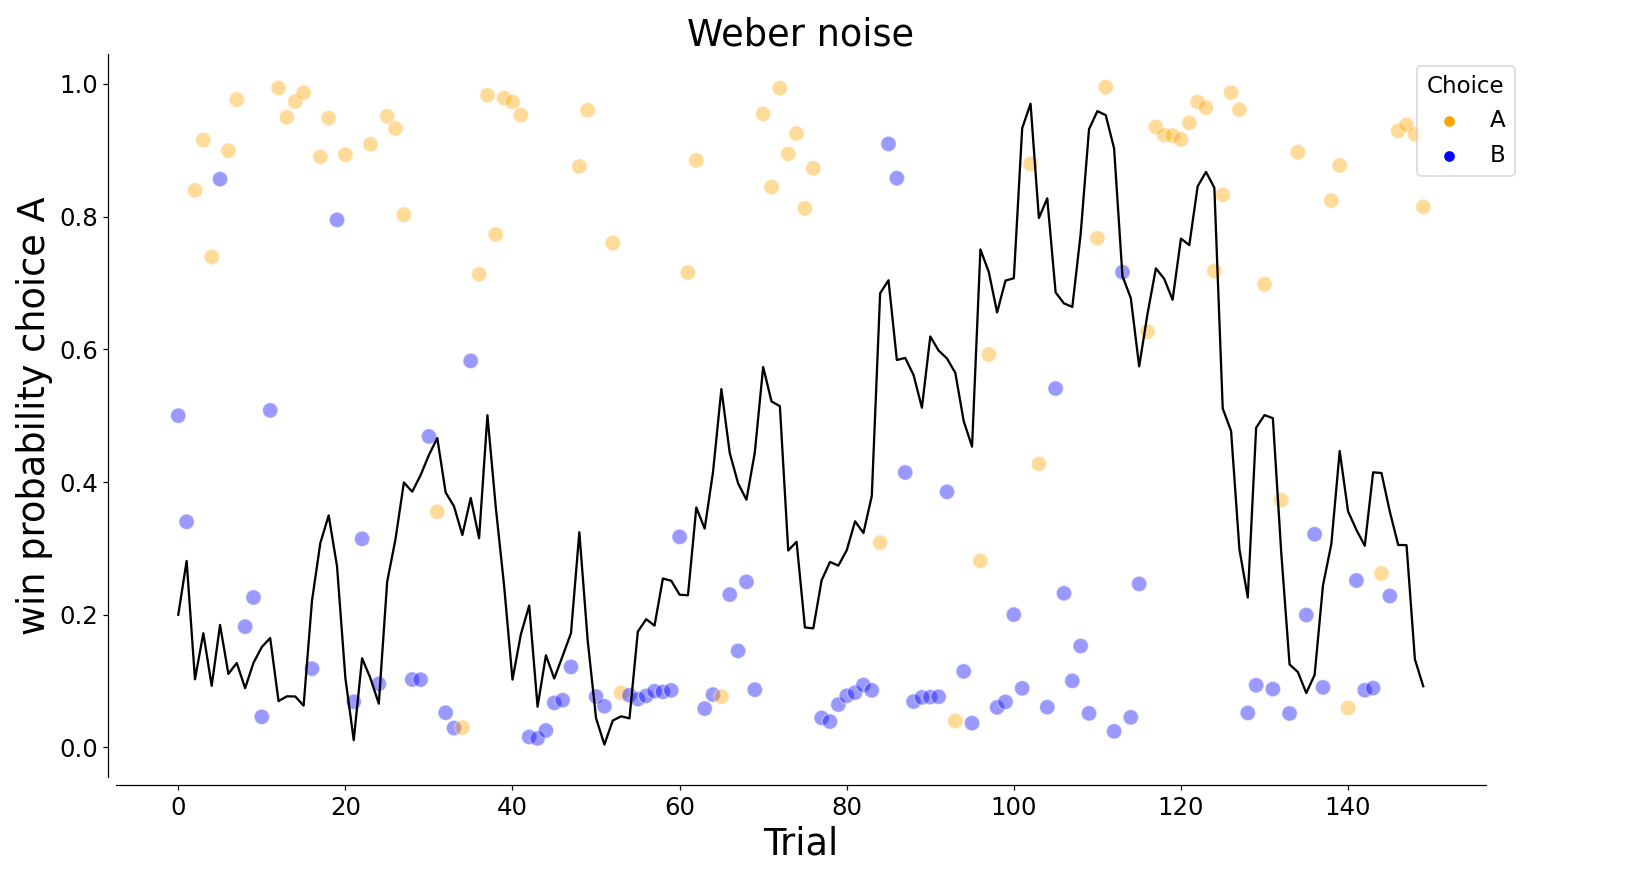

Weber: simulated choice


<IPython.core.display.Javascript object>


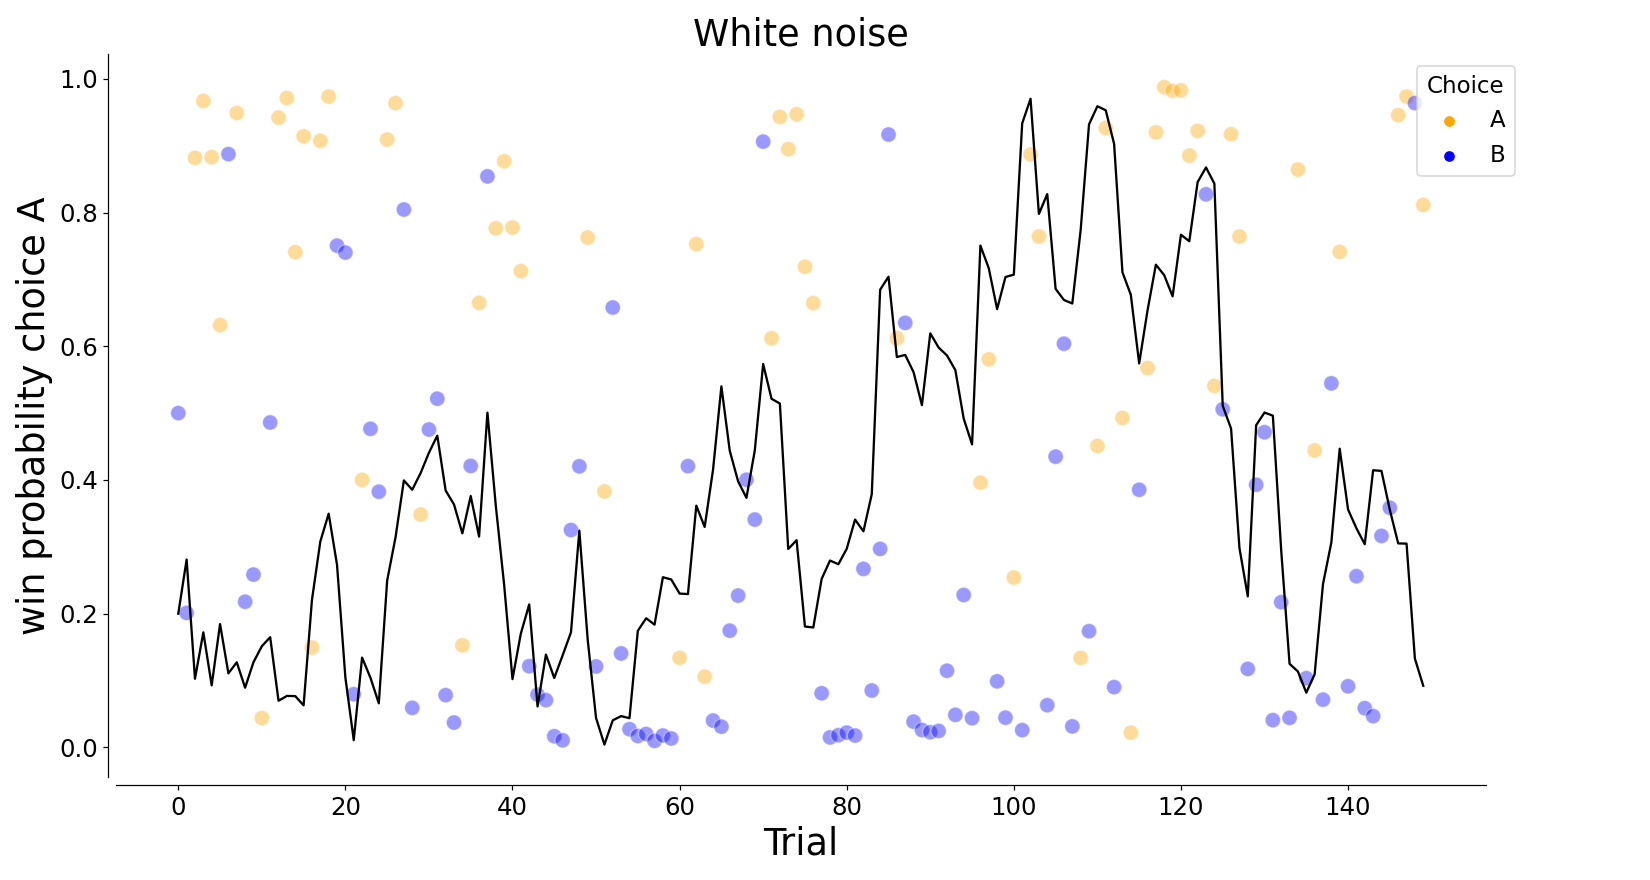

White: simulated choice


<IPython.core.display.Javascript object>


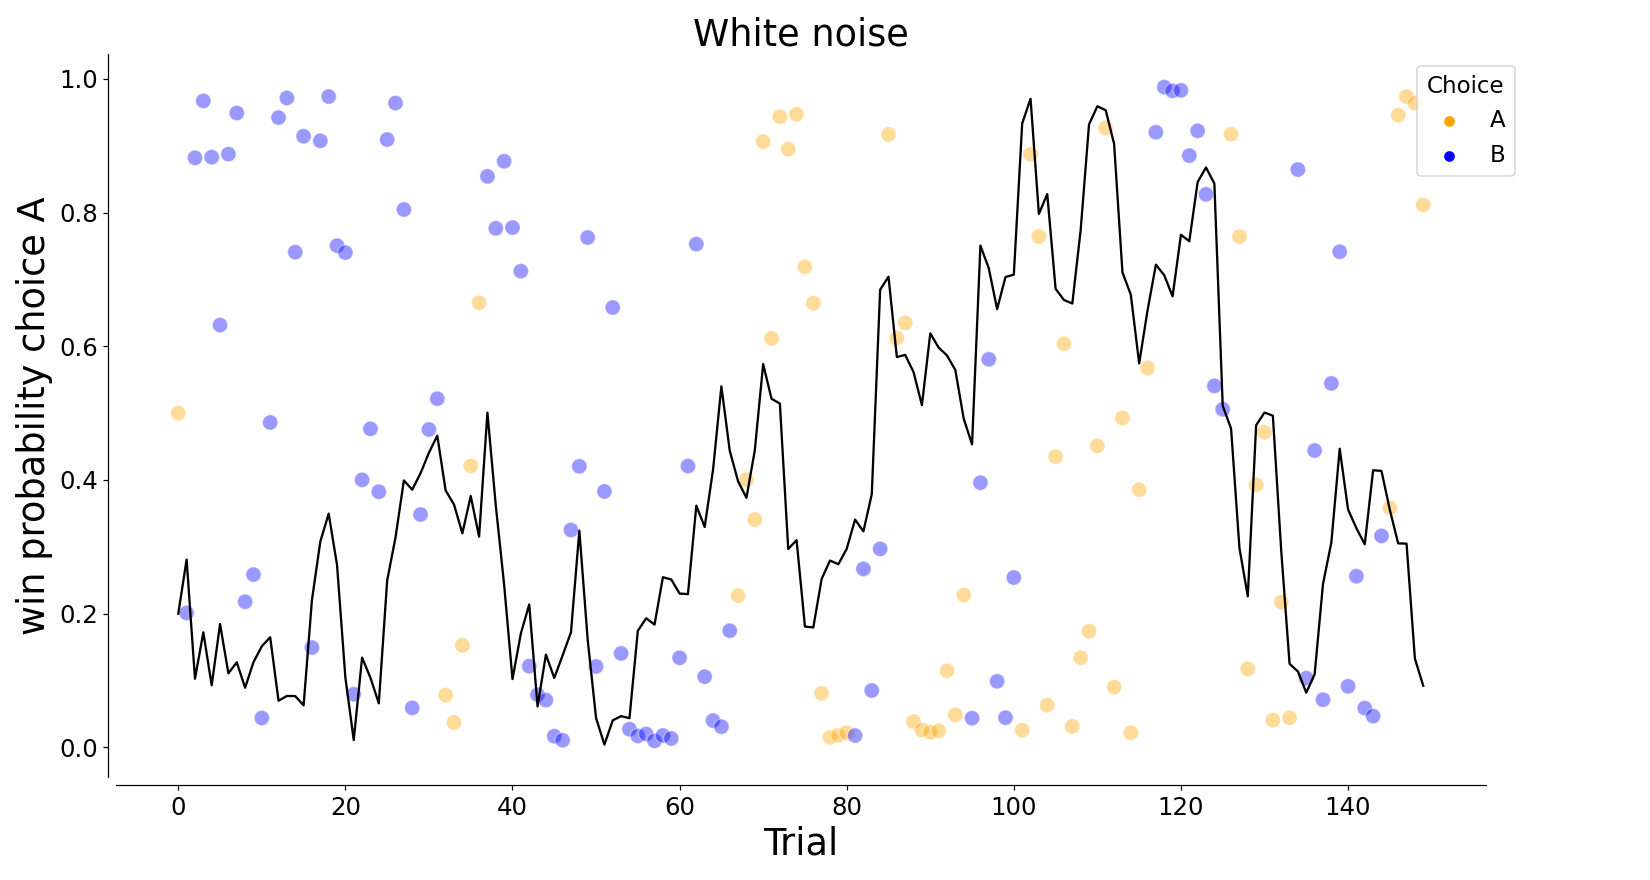

True choice


<IPython.core.display.Javascript object>


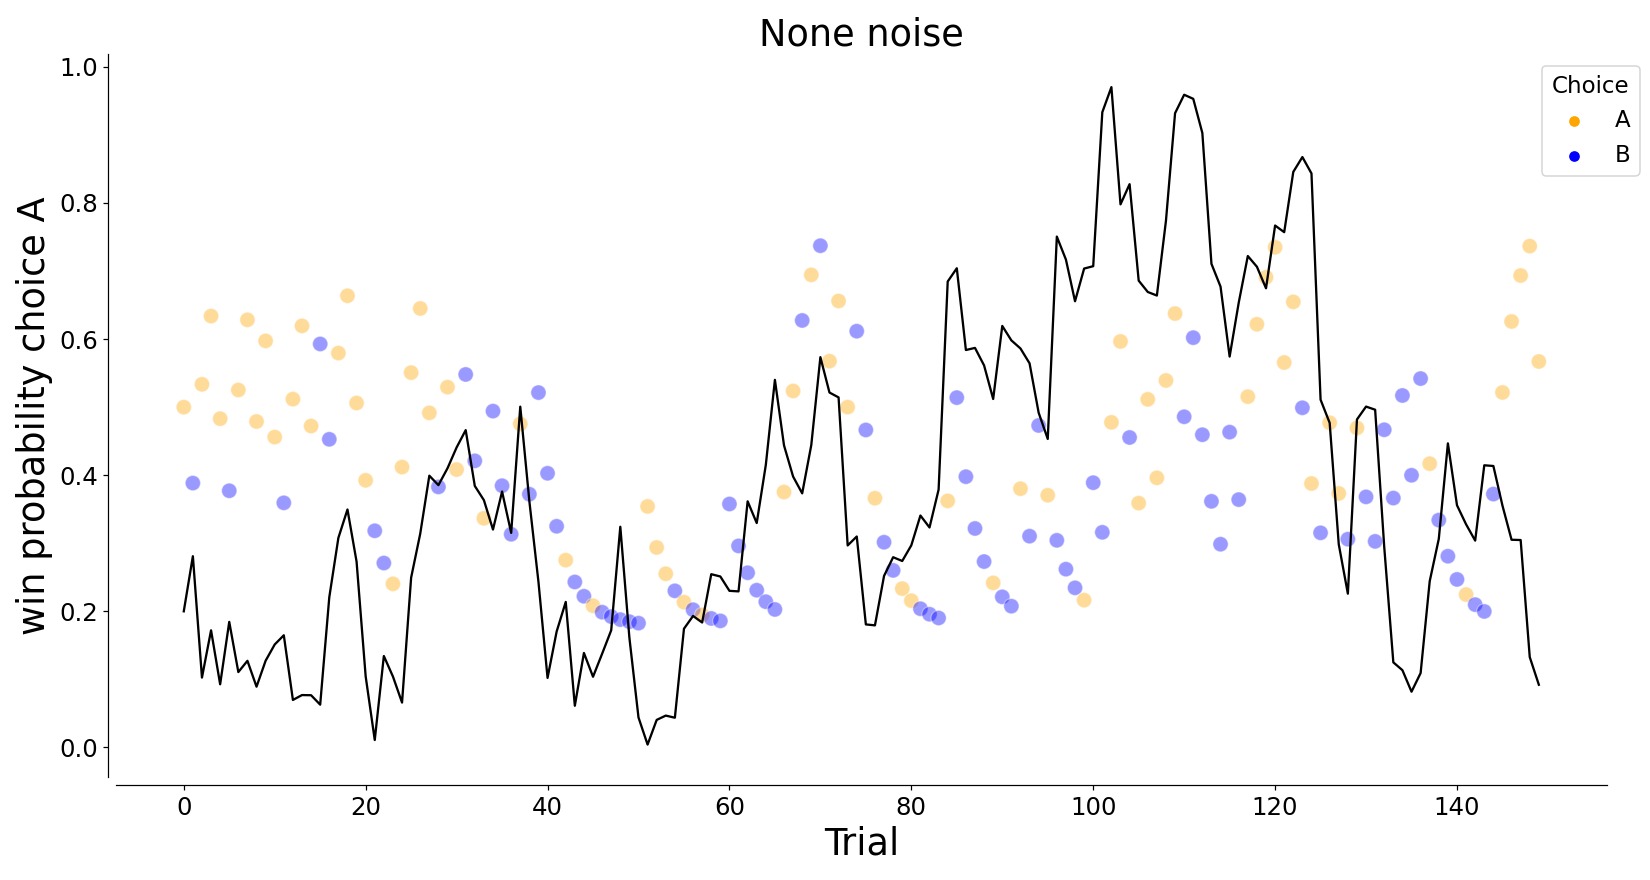

None: simulated choice


<IPython.core.display.Javascript object>


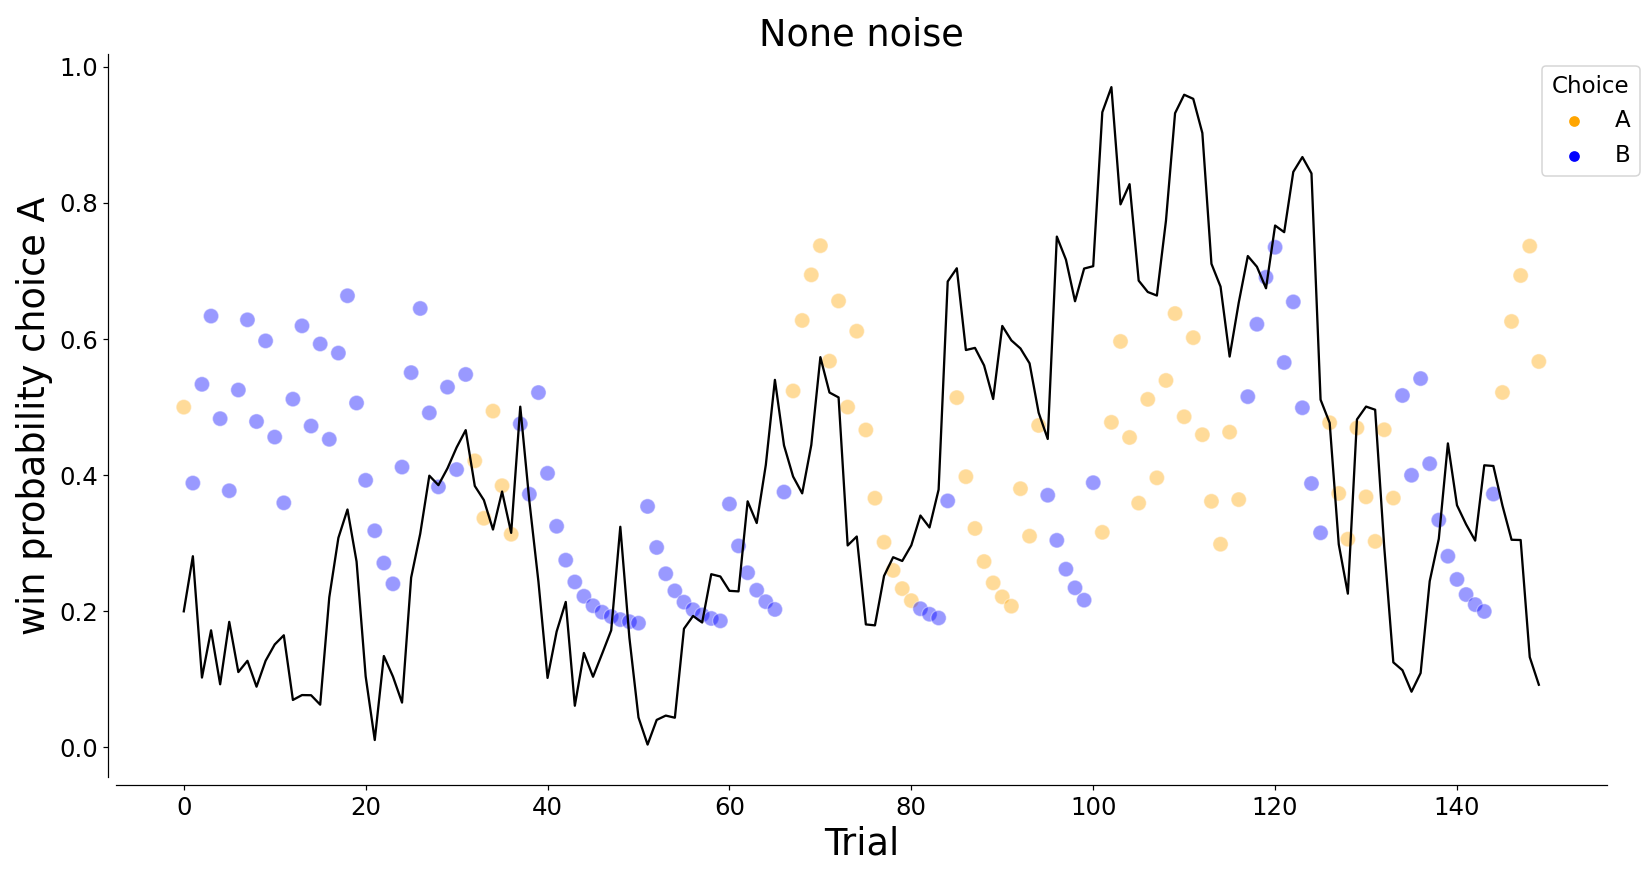

True choice


In [92]:
visualize(df, 4, 24, 'Weber', 'True')
visualize(df, 4, 24, 'Weber', 'simulated')
visualize(df, 4, 24, 'White', 'simulated')
visualize(df, 4, 24, 'White', 'True')
visualize(df, 4, 24, 'None', 'simulated')
visualize(df, 4, 24, 'None', 'True')

In [55]:
sub=4

In [57]:
tt=np.load('C:/Users/canlab/Desktop/Modelling_Influenca/Results/Fit_all_subjects/Fitting_results/subject_{}_median_parameters_all_models.pkl'.format(sub), allow_pickle=True)

In [61]:
lkd_df=pd.DataFrame(tt[3])


In [63]:
lkd_df.columns=['Weber', 'White', 'None']
lkd_df

,Weber,White,None
0,-88.196072,-88.344561,-93.198634
1,-70.888338,-71.318952,-82.082932
2,-54.402455,-55.882352,-62.051083
3,-46.581652,-46.110293,-50.307899
4,-80.763964,-80.857839,-85.898788
5,-65.874036,-68.134185,-73.750492
6,-52.471266,-51.710102,-57.369797
7,-50.565170,-50.149808,-54.731247
8,-62.343602,-64.137307,-67.125408
9,-36.244991,-36.086901,-44.975468


In [64]:
lkd_df.to_csv('C:/Users/canlab/Desktop/Modelling_Influenca/Results/Fit_all_subjects/Fitting_results/Subject_4_LLKD.csv')